In [ ]:
import numpy as np
dataset = "NYCBike2"
data_path = fr"D:\omer\ST-SSL\data\{dataset}\train.npz"
x_train = np.load(data_path)["x"]
y_train = np.load(data_path)["y"]
extreme_values_binary_tensor = np.load(data_path)["evs_90"]
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}, evs.shape: {extreme_values_binary_tensor.shape}")

: 

In [2]:
# ## plot from the gt EVs

# import numpy as np
# import matplotlib.pyplot as plt

# # Set up the plot
# plt.figure(figsize=(15, 10))

# # Plotting for the first node (as the loop range is 1, it plots only the first node)
# for node_index in range(1):
#     inflow = y_train[:, 0, node_index, 0]
#     outflow = y_train[:, 0, node_index, 1]
    
#     # Extract extreme indicators for inflow and outflow
#     extreme_inflow_indicator = extreme_values_binary_tensor[:, 0, node_index, 0]
#     # extreme_outflow_indicator = extreme_values_binary_tensor[:, 0, node_index, 1]
    
#     # Identify indices where extreme events occur
#     extreme_inflow_indices = np.where(extreme_inflow_indicator == 1)[0]
#     # extreme_outflow_indices = np.where(extreme_outflow_indicator == 1)[0]

#     # Plotting inflow and outflow
#     plt.subplot(1, 1, node_index + 1)
#     plt.plot(inflow, label='Inflow')
#     # plt.plot(outflow, label='Outflow')

#     # Marking the extreme events
#     plt.scatter(extreme_inflow_indices, inflow[extreme_inflow_indices], color='red', label='Extreme Inflow', marker='o')
#     # plt.scatter(extreme_outflow_indices, outflow[extreme_outflow_indices], color='blue', label='Extreme Outflow', marker='x')

#     plt.title(f'Node {node_index + 1}')
#     plt.xlabel('Time (sample index)')
#     plt.ylabel('Flow')
#     plt.legend()

# plt.tight_layout()
# plt.show()


## plotting evs from the learnt classifier

In [3]:


import warnings 
warnings.filterwarnings('ignore')
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
sys.path.append('.')
sys.path.append('..')
import yaml 
import argparse
import traceback
import time
import torch

from model.models import STSSL
from model.trainer import Trainer
from lib.dataloader import get_dataloader
from lib.utils import (
    init_seed,
    get_model_params,
    load_graph, 
)

In [4]:
import time
import yaml

# Define your configurations directly
configs = {
    'config_filename': 'configs/NYCBike2.yaml',
    'S_Loss': 0,
    'T_Loss': 0,
    'seed': 1,
    'comment': "noComment",
    'cheb_order': 3,
    'graph_init': "8_neighbours",
    'self_attention_flag': True,
    'cross_attention_flag': False,
    'feedforward_flag': False,
    'layer_norm_flag': False,
    'additional_sa_flag': False,
    'learnable_flag': False,
    'rank': 0,
    'pos_emb_flag': False,
    'add_8': True,
    'add_eye': False,
    'add_x_encoder': False,
    'freeze_encoder': False,
    'ipe': 1
}

# Optionally print the starting experiment configurations
print(f"Starting experiment with configurations in {configs['config_filename']}...")

# Simulate a brief pause
time.sleep(3)

# Load configurations from a file (if necessary, or you could just use the dictionary as is)
with open(configs['config_filename'], 'r') as file:
    file_configs = yaml.load(file, Loader=yaml.FullLoader)
    configs.update(file_configs)

# You can add logic to modify configurations based on your conditions here
experiment_name = "pred_"
if configs['S_Loss'] == 1:
    experiment_name += "+S"
if configs['T_Loss'] == 1:
    experiment_name += "+T"
experiment_name += f"_seed={configs['seed']}"

configs['comment'] = "noComment"
configs['ipe'] = 1000
configs['loss'] = "mae"
configs['threshold_adj_mx'] = False
configs['affinity_conv'] = False
configs["experimentName"] = experiment_name
configs["load_path"] = None

# Print the final configuration to start the experiment
print(f"Starting experiment with configurations {configs}...")
args = argparse.Namespace(**configs)

Starting experiment with configurations in configs/NYCBike2.yaml...
Starting experiment with configurations {'config_filename': 'configs/NYCBike2.yaml', 'S_Loss': 0, 'T_Loss': 0, 'seed': 1, 'comment': 'noComment', 'cheb_order': 3, 'graph_init': '8_neighbours', 'self_attention_flag': True, 'cross_attention_flag': False, 'feedforward_flag': False, 'layer_norm_flag': False, 'additional_sa_flag': False, 'learnable_flag': False, 'rank': 0, 'pos_emb_flag': False, 'add_8': True, 'add_eye': False, 'add_x_encoder': False, 'freeze_encoder': False, 'ipe': 1000, 'device': 'cuda', 'mode': 'train', 'best_path': 'None', 'debug': False, 'data_dir': 'data', 'dataset': 'NYCBike2', 'input_length': 35, 'batch_size': 32, 'test_batch_size': 32, 'graph_file': 'data/NYCBike2/adj_mx.npz', 'num_nodes': 200, 'row': 20, 'col': 10, 'd_input': 2, 'd_output': 2, 'd_model': 64, 'dropout': 0.3, 'percent': 0.1, 'shm_temp': 0.5, 'nmb_prototype': 10, 'yita': 0.5, 'start_epoch': 0, 'num_epochs': 1000, 'epochs': 1000, 'lr_

In [5]:
init_seed(args.seed)
if not torch.cuda.is_available():
    args.device = 'cuda'

## load dataset
dataloader = get_dataloader(
    data_dir=args.data_dir, 
    dataset=args.dataset, 
    batch_size=args.batch_size, 
    test_batch_size=args.test_batch_size,
    scalar_type='Standard'
)
graph = load_graph(args.graph_file, device=args.device)
args.num_nodes = len(graph)

## init model and set optimizer

args.best_path = r'D:\omer\ST-SSL\experiments\NYCBike2\pred__seed=1\20240806-015146\cls lr 0.1, wd bias minus 5, annealing\best_model.pth'
# args.best_path = r'D:\omer\ST-SSL\experiments\NYCTaxi\pred__seed=1\20240805-153552\denormalize then scale\best_model.pth'
model_dir = os.path.dirname(args.best_path)
sys.path.append(model_dir)
from models import STSSL

model = STSSL(args).to(args.device)

state_dict = torch.load(
                args.best_path,
                map_location=torch.device(args.device)
            )

# Dictionary to map from unexpected keys to expected keys
# key_map = {
#     "learnable_vectors": "learnable_vectors_bias",
#     "mlp_classifier.fc1.linear.weight": "mlp_cls.fc1.linear.weight",
#     "mlp_classifier.fc1.linear.bias": "mlp_cls.fc1.linear.bias",
#     "mlp_classifier.fc2.linear.weight": "mlp_cls.fc2.linear.weight",
#     "mlp_classifier.fc2.linear.bias": "mlp_cls.fc2.linear.bias",
#     "ff_key_projection.linear1.weight": "ff_key_projection_bias.linear1.weight",
#     "ff_key_projection.linear1.bias": "ff_key_projection_bias.linear1.bias",
#     "ff_key_projection.linear2.weight": "ff_key_projection_bias.linear2.weight",
#     "ff_key_projection.linear2.bias": "ff_key_projection_bias.linear2.bias",
#     "ff_to_classify.linear1.weight": "ff_to_cls.linear1.weight",
#     "ff_to_classify.linear1.bias": "ff_to_cls.linear1.bias",
#     "ff_to_classify.linear2.weight": "ff_to_cls.linear2.weight",
#     "ff_to_classify.linear2.bias": "ff_to_cls.linear2.bias"
# }

# # Create a new state_dict with corrected keys
# # Create a new state_dict with corrected keys
# new_state_dict = {}
# for k, v in state_dict["model"].items():
#     if k in key_map:
#         new_state_dict[key_map[k]] = v  # Remap to new key
#     else:
#         new_state_dict[k] = v  # Keep as is if not in key map

msg = model.load_state_dict(state_dict["model"])
print("Load saved model msg: ", msg)

model_parameters = get_model_params([model])
optimizer = torch.optim.Adam(
    params=model_parameters, 
    lr=args.lr_init, 
    eps=1.0e-8, 
    weight_decay=0, 
    amsgrad=False
)

using 90percent evs
using 90percent evs
using 90percent evs


!!Scaling is NOT off!!


data['x_train'].shape:  (1912, 35, 200, 2) (1912, 1, 200, 2) 

!!train shuffle is True!!


in else
in else
in else
in else
Load saved model msg:  <All keys matched successfully>


In [6]:


## start training
trainer = Trainer(
    model=model, 
    optimizer=optimizer, 
    dataloader=dataloader,
    graph=graph, 
    args=args
)

2024-08-06 11:24:10: 
Model has 2.414672 M trainable parameters
2024-08-06 11:24:10: Experiment log path in: D:\omer\ST-SSL\experiments\NYCBike2\pred__seed=1\20240806-112410\noComment
2024-08-06 11:24:10: Experiment configs are: Namespace(S_Loss=0, T_Loss=0, add_8=True, add_eye=False, add_x_encoder=False, additional_sa_flag=False, affinity_conv=False, batch_size=32, best_path='D:\\omer\\ST-SSL\\experiments\\NYCBike2\\pred__seed=1\\20240806-015146\\cls lr 0.1, wd bias minus 5, annealing\\best_model.pth', cheb_order=3, col=10, comment='noComment', config_filename='configs/NYCBike2.yaml', cross_attention_flag=False, d_input=2, d_model=64, d_output=2, data_dir='data', dataset='NYCBike2', debug=False, device='cuda', dropout=0.3, early_stop=True, early_stop_patience=30, epochs=1000, experimentName='pred__seed=1', feedforward_flag=False, freeze_encoder=False, grad_norm=True, graph_file='data/NYCBike2/adj_mx.npz', graph_init='8_neighbours', input_length=35, ipe=1000, layer_norm_flag=False, lea

dummy forward pass done.
Creat Log File in:  D:\omer\ST-SSL\experiments\NYCBike2\pred__seed=1\20240806-112410\noComment\run.log


In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from lib.metrics import test_metrics


def test(model, dataloader, scaler, graph, logger, args):
    model.eval()
    evs_true = []
    evs_pred = []
    y_pred = []
    y_true = []
    o_tilde = []
    bias = []
    with torch.no_grad():
        for batch_idx, (data, target, evs) in enumerate(dataloader):
            repr1, repr1_cls = model(data, graph)          
            o_tilde_value = model.predict_o_tilde(repr1)      
            pred_output = model.predict(repr1, repr1_cls)
            evs_predicted = model.get_evs(repr1_cls)
            bias_value = model.get_bias(repr1)
            y_true.append(target)
            y_pred.append(pred_output)
            evs_true.append(evs)
            evs_pred.append(evs_predicted)
            o_tilde.append(o_tilde_value)
            bias.append(bias_value)

    # y_true = torch.cat(y_true, dim=0).cpu().numpy()
    # y_pred = torch.cat(y_pred, dim=0).cpu().numpy()
    
    evs_true = torch.cat(evs_true, dim=0).cpu().numpy()
    evs_pred = torch.cat(evs_pred, dim=0).cpu().numpy()
    bias = torch.cat(bias, dim=0).cpu().numpy()
    bias = scaler.inverse_transform(bias)
    
    bias_scaled = bias*evs_pred
    # bias_scaled = scaler.inverse_transform(bias_scaled)
    
    y_true = scaler.inverse_transform(torch.cat(y_true, dim=0)).cpu().numpy()
    y_pred = scaler.inverse_transform(torch.cat(y_pred, dim=0)).cpu().numpy()
    o_tilde = scaler.inverse_transform(torch.cat(o_tilde, dim=0)).cpu().numpy()
    
    mask = np.where(y_true > (5), True, False)
    # true = true[mask]
    # pred = pred[mask]
    test_results = []
    # inflow
    mae, mape = test_metrics(y_pred[..., 0], y_true[..., 0])
    logger.info("test, MAE: {:.2f}, test MAPE: {:.4f}%".format(mae, mape*100))
    test_results.append([mae, mape])
    
    print("y_true.shape: ", y_true.shape, "y_pred.shape: ", y_pred.shape)

    # Plotting
    plt.figure(figsize=(10, 5))
    
    ## to plot all regions 
    # plt.plot(y_true[..., 0].flatten()[3000:4000], label='True Values')
    # plt.plot(y_pred[..., 0].flatten()[3000:4000], label='Predictions')
    ## to plot summed up regions
    # plt.plot(np.sum(y_true[:, :, :, :], axis=2).flatten()
    #         , label='True Values')
    # plt.plot(np.sum(y_pred[:, :, :, :], axis=2).flatten(), label='Predictions')
    mask = y_true > 5

    # Apply the mask to y_true and y_pred to filter values
    masked_y_true = np.where(mask, y_true, np.nan)  # Replace unmasked values with NaN
    masked_y_pred = np.where(mask, y_pred, np.nan)  # Same for y_pred
    print("masked_y_true.shape: ", masked_y_true.shape, "masked_y_pred.shape: ", masked_y_pred.shape)
    # Sum and flatten the masked values for plotting
    # Using np.nansum to ignore NaN values in summation
    summed_masked_y_true = np.nansum(masked_y_true, axis=2).flatten()
    summed_masked_y_pred = np.nansum(masked_y_pred, axis=2).flatten()
    plt.plot(summed_masked_y_true, label='True Values (Masked)', color='blue', linewidth=2, linestyle='-')
    plt.plot(summed_masked_y_pred, label='Predictions (Masked)', color='red', linewidth=2, linestyle='--')
    plt.title("Comparison of True and Predicted Values")
    plt.xlabel("Sample")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    # outflow 
    mae, mape = test_metrics(y_pred[..., 1], y_true[..., 1])
    logger.info("OUTFLOW, MAE: {:.2f}, MAPE: {:.4f}%".format(mae, mape*100))
    # test_results.append([mae, mape]) 

    return np.stack(test_results, axis=0), y_true, y_pred, evs_true, evs_pred, o_tilde, bias, bias_scaled


2024-08-06 11:24:21: test, MAE: 4.94, test MAPE: 21.9474%


y_true.shape:  (546, 1, 200, 2) y_pred.shape:  (546, 1, 200, 2)
masked_y_true.shape:  (546, 1, 200, 2) masked_y_pred.shape:  (546, 1, 200, 2)


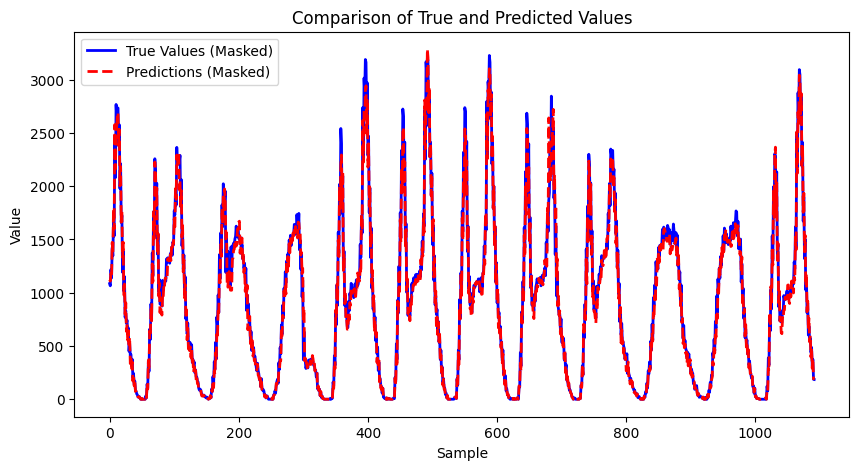

2024-08-06 11:24:22: OUTFLOW, MAE: 4.60, MAPE: 21.0339%


In [10]:
## mse
s, y_true, y_pred, evs_true, evs_pred, o_tilde, bias, bias_scaled = test(model, dataloader['test'], dataloader['scaler'],
            graph, trainer.logger, trainer.args)

In [9]:
# ## plot from the newly defined binary tensor

# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming y_train and extreme_indicator_tensor are defined with the same shape
# # and extreme_indicator_tensor contains 1 where there's an extreme event and 0 otherwise

# # Set up the plot
# plt.figure(figsize=(25, 20))

# # Plotting for the first node (as the loop range is 1, it plots only the first node)
# s, e = 150, 350
# node_indices = [3, 4]
# for i, node_index in enumerate(node_indices):
#     inflow = y_true[s:e, 0, node_index, 0]
#     inflow_pred = y_pred[s:e, 0, node_index, 0]
#     inflow_o_tilde = o_tilde[s:e, 0, node_index, 0]
#     # outflow = y_train[:, 0, node_index, 1]
    
#     inflow_evs = evs_pred[s:e, 0, node_index, 0] * 50
#     # Extract extreme indicators for inflow and outflow
#     extreme_inflow_indicator = evs_pred[s:e, 0, node_index, 0]
#     extreme_inflow_indicator_true = evs_true[s:e, 0, node_index, 0]
#     # print("extreme_inflow_indicator", extreme_inflow_indicator)
#     # extreme_outflow_indicator = extreme_values_binary_tensor[:, 0, node_index, 1]
    
#     # Identify indices where extreme events occur
#     extreme_inflow_indices = np.where(extreme_inflow_indicator >= .5)[0]
#     extreme_inflow_indices_true = np.where(extreme_inflow_indicator_true == 1)[0]
#     # extreme_outflow_indices = np.where(extreme_outflow_indicator == 1)[0]

#     # Plotting inflow and outflow
#     plt.subplot(int(len(node_indices)), 1, i + 1)
#     plt.plot(inflow, label='Inflow')
#     plt.plot(inflow_pred, label='Inflow_pred')
#     plt.plot(inflow_o_tilde, label='o_tilde')
#     plt.plot(inflow_evs, label='extreme value indicator - scaled ')
#     # plt.plot(outflow, label='Outflow')

#     # Marking the extreme events
#     plt.scatter(extreme_inflow_indices_true, inflow[extreme_inflow_indices_true], color='green', label='Extreme Inflow _ gt', marker='o')
#     plt.scatter(extreme_inflow_indices, inflow[extreme_inflow_indices], color='red', label='Extreme Inflow _ pred', marker='x')
    
#     # plt.scatter(extreme_outflow_indices, outflow[extreme_outflow_indices], color='blue', label='Extreme Outflow', marker='x')

#     plt.title(f'Node {node_index}')
#     plt.xlabel('Time (sample index)')
#     plt.ylabel('Flow')
#     plt.legend()

# plt.tight_layout()
# plt.show()


torch.Size([1, 1, 128, 2])


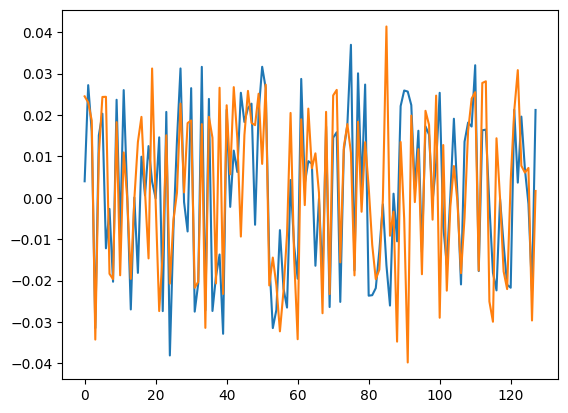

In [11]:
lv = model.learnable_vectors_bias
print(lv.shape)
lv_in = lv[0, 0, :, 0].cpu().detach().numpy()
lv_out = lv[0, 0, :, 1].cpu().detach().numpy()
lv_in.shape
plt.plot(lv_in)
plt.plot(lv_out)

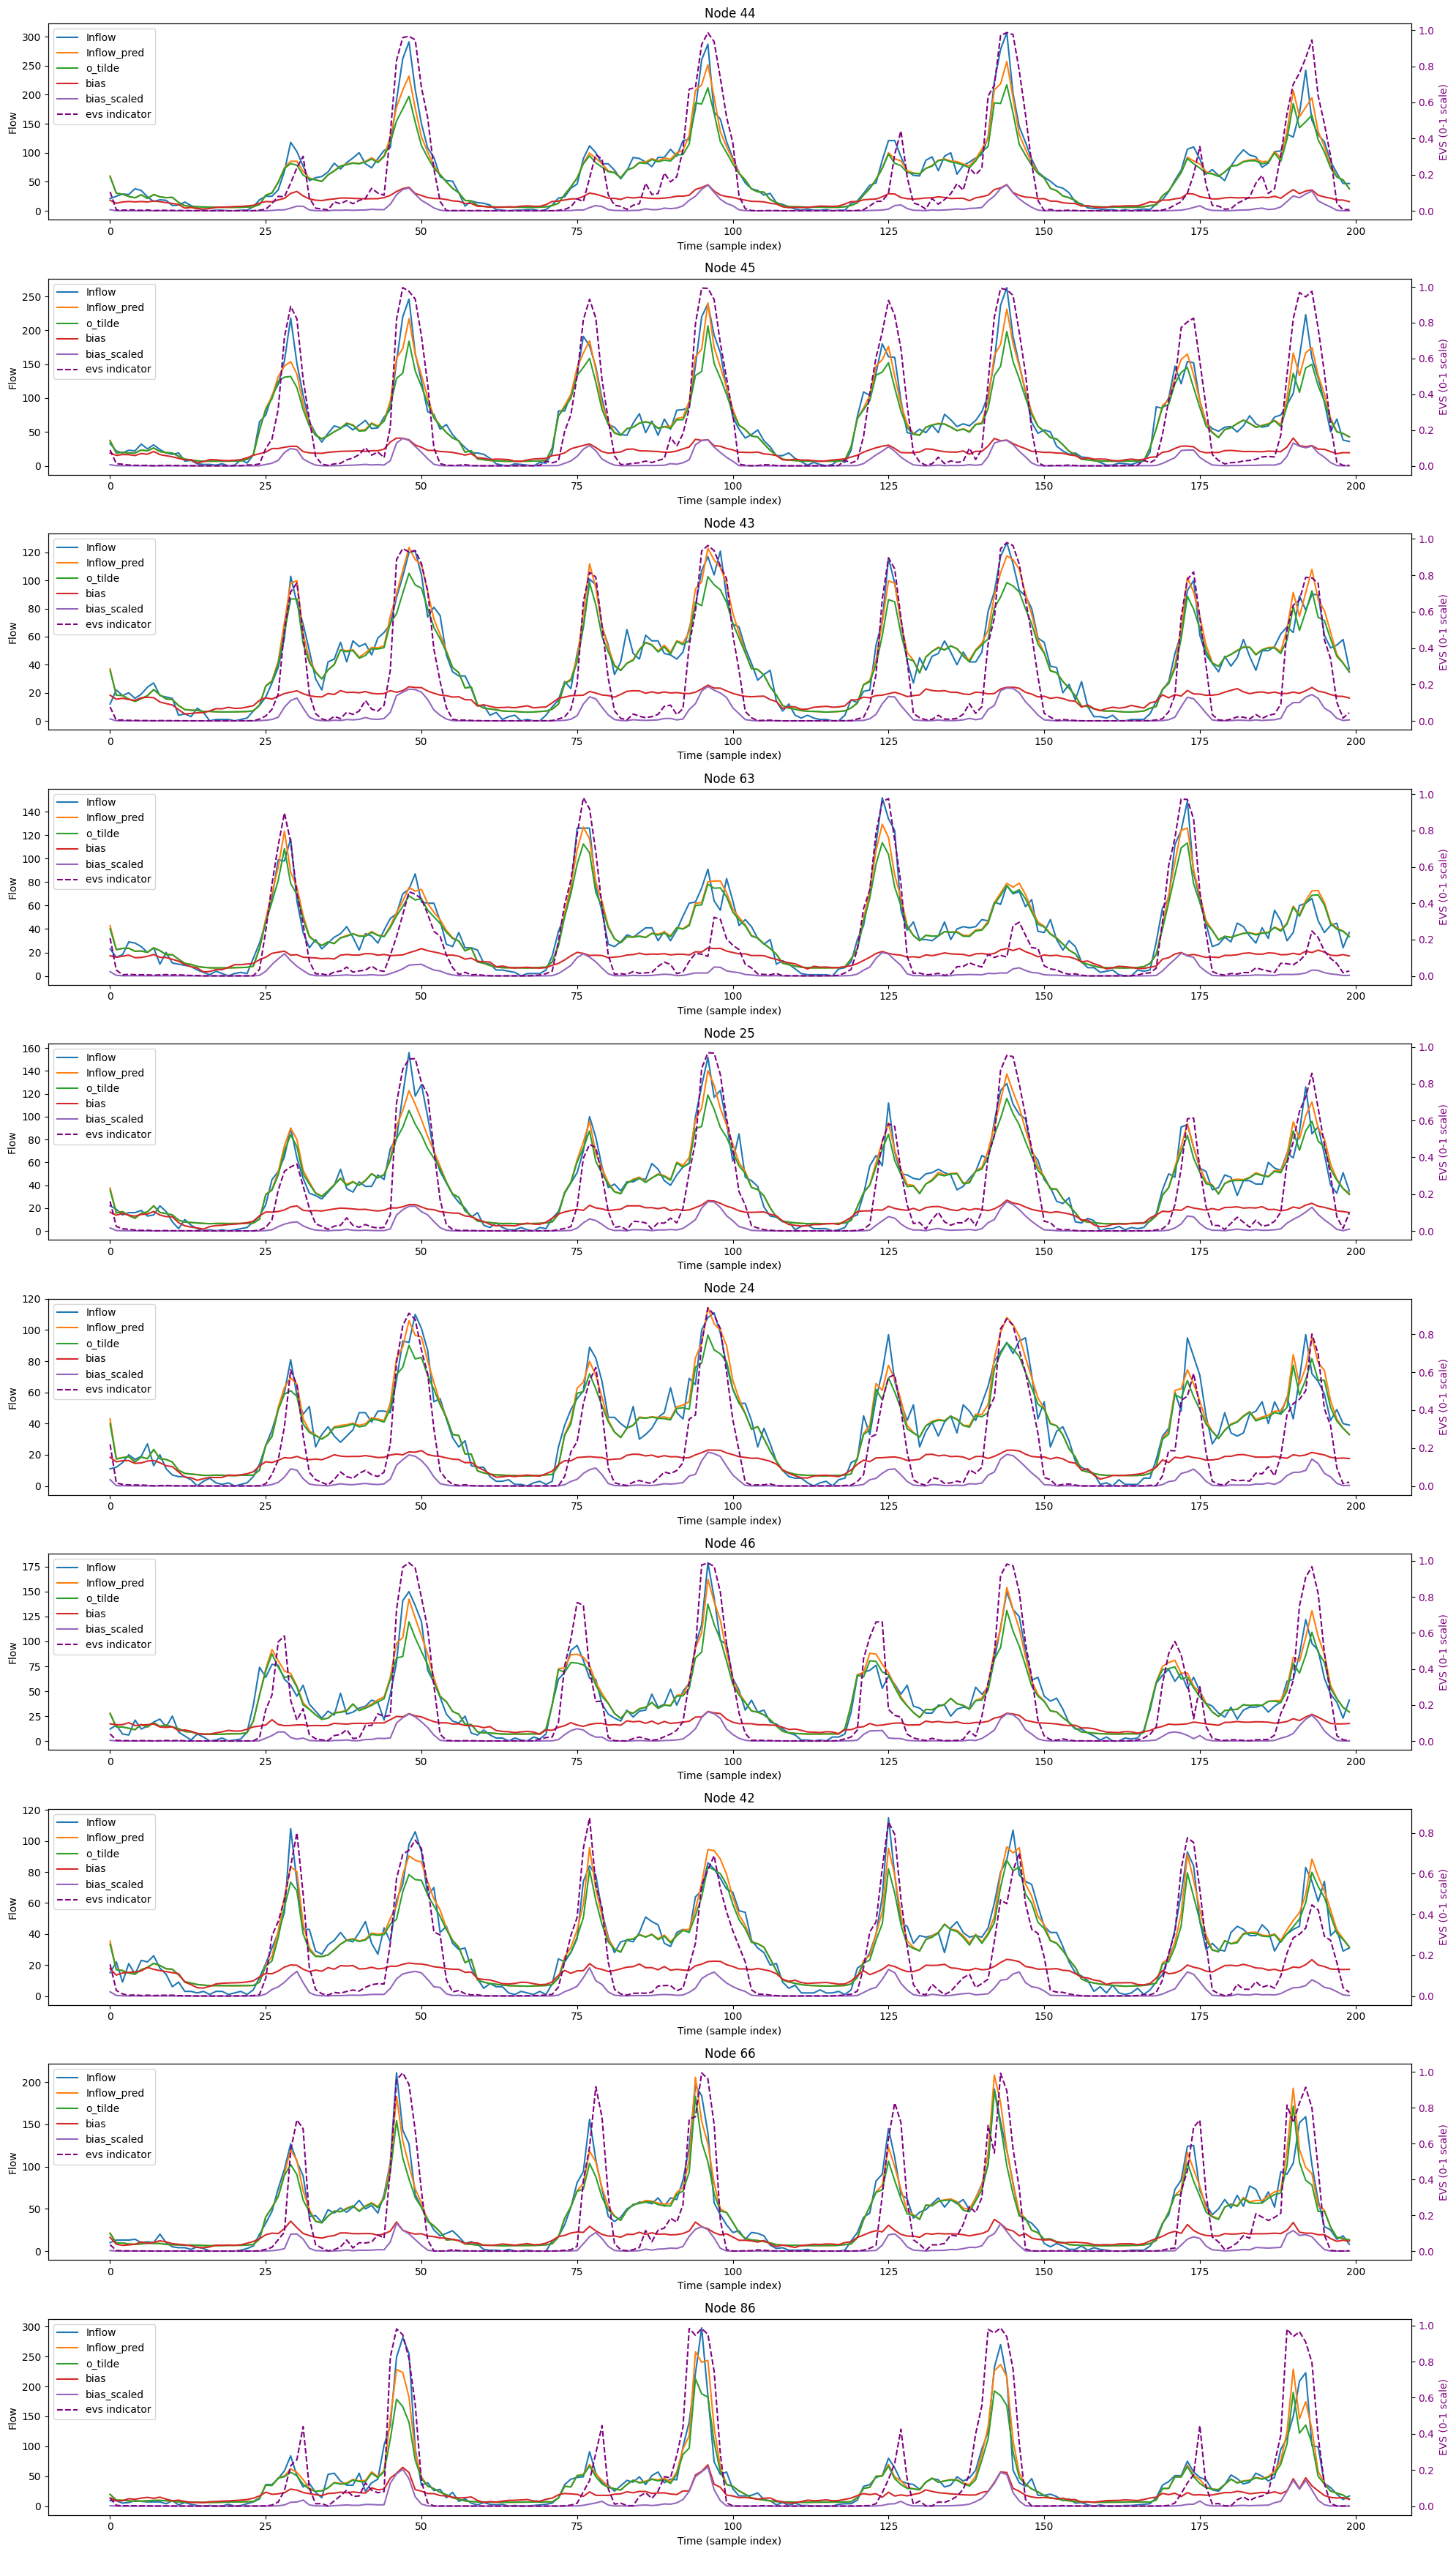

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(20, 35))

s, e = 150, 350
node_indices = [44, 45, 43, 63, 25, 24, 46, 42, 66, 86]
# node_indices = [i for i in range(25, 50)]
for i, node_index in enumerate(node_indices):
    inflow = y_true[s:e, 0, node_index, 0]
    inflow_pred = y_pred[s:e, 0, node_index, 0]
    inflow_o_tilde = o_tilde[s:e, 0, node_index, 0]
    inflow_bias = bias[s:e, 0, node_index, 0]
    inflow_bias_scaled = bias_scaled[s:e, 0, node_index, 0]

    inflow_evs = evs_pred[s:e, 0, node_index, 0]
    extreme_inflow_indicator = evs_pred[s:e, 0, node_index, 0]
    extreme_inflow_indicator_true = evs_true[s:e, 0, node_index, 0]
    
    extreme_inflow_indices = np.where(extreme_inflow_indicator >= .5)[0]
    extreme_inflow_indices_true = np.where(extreme_inflow_indicator_true == 1)[0]

    # Plotting inflow
    ax1 = plt.subplot(len(node_indices), 1, i + 1)
    ax1.plot(inflow, label='Inflow')
    ax1.plot(inflow_pred, label='Inflow_pred')
    ax1.plot(inflow_o_tilde, label='o_tilde')
    ax1.plot(inflow_bias, label='bias')
    ax1.plot(inflow_bias_scaled, label='bias_scaled')
    # ax1.scatter(extreme_inflow_indices_true, inflow[extreme_inflow_indices_true], color='green', label='Extreme Inflow _ gt', marker='o')
    # ax1.scatter(extreme_inflow_indices, inflow[extreme_inflow_indices], color='red', label='Extreme Inflow _ pred', marker='x')
    
    ax1.set_title(f'Node {node_index}')
    ax1.set_xlabel('Time (sample index)')
    ax1.set_ylabel('Flow')

    # Create a second y-axis for the extreme value scale
    ax2 = ax1.twinx()
    ax2.plot(inflow_evs, label='evs indicator', color='purple', linestyle='--')
    ax2.set_ylabel('EVS (0-1 scale)', color='purple')
    ax2.tick_params(axis='y', labelcolor='purple')

    # Adding legend separately for clarity
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()


evaluating the classifier

In [12]:
# evs_true, evs_pred
# evs_true.shape

import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
                             balanced_accuracy_score, roc_auc_score, precision_recall_curve, auc)
# Threshold predictions at 0.2
evs_pred_binary = (evs_pred >= 0.5).astype(int)

# Flatten the arrays to fit the metrics functions
evs_true_flat = evs_true.flatten()
evs_pred_flat = evs_pred_binary.flatten()
evs_pred_probs_flat = evs_pred.flatten()  # Use raw probabilities for AUC and precision-recall calculations

# Calculate metrics
accuracy = accuracy_score(evs_true_flat, evs_pred_flat)
precision = precision_score(evs_true_flat, evs_pred_flat)
recall = recall_score(evs_true_flat, evs_pred_flat)
f1 = f1_score(evs_true_flat, evs_pred_flat)
balanced_acc = balanced_accuracy_score(evs_true_flat, evs_pred_flat)
roc_auc = roc_auc_score(evs_true_flat, evs_pred_probs_flat)

# Precision-Recall Curve and AUC
precision_points, recall_points, _ = precision_recall_curve(evs_true_flat, evs_pred_probs_flat)
auc_pr = auc(recall_points, precision_points)

# Display the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Balanced Accuracy:", balanced_acc)
print("ROC AUC:", roc_auc)
print("Precision-Recall AUC:", auc_pr)



Accuracy: 0.9408699633699634
Precision: 0.5554138095997448
Recall: 0.2559335733705636
F1 Score: 0.35040241448692155
Balanced Accuracy: 0.621159846927187
ROC AUC: 0.8598714008799652
Precision-Recall AUC: 0.3895731043940137


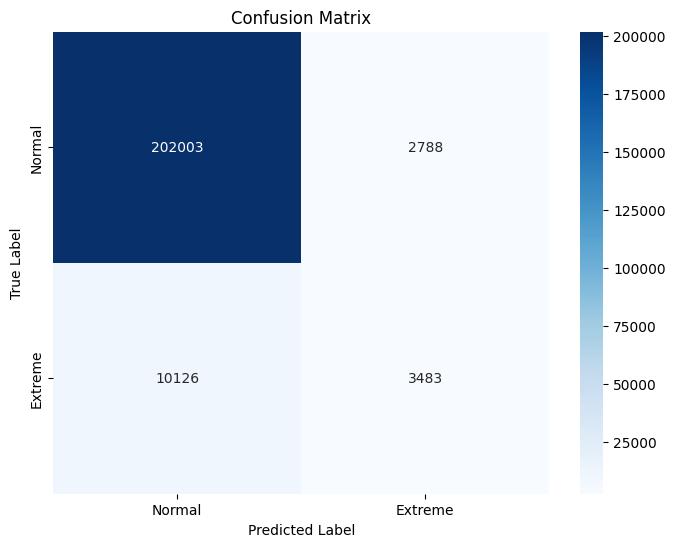

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

# Example data, replace these with your actual data
evs_pred_binary = (evs_pred >= 0.5).astype(int)       # Threshold predictions at 0.2

# Flatten the arrays
evs_true_flat = evs_true.flatten()
evs_pred_flat = evs_pred_binary.flatten()

# Calculate confusion matrix
conf_matrix = confusion_matrix(evs_true_flat, evs_pred_flat)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Normal", "Extreme"], yticklabels=["Normal", "Extreme"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


PLOT true pred evs bias

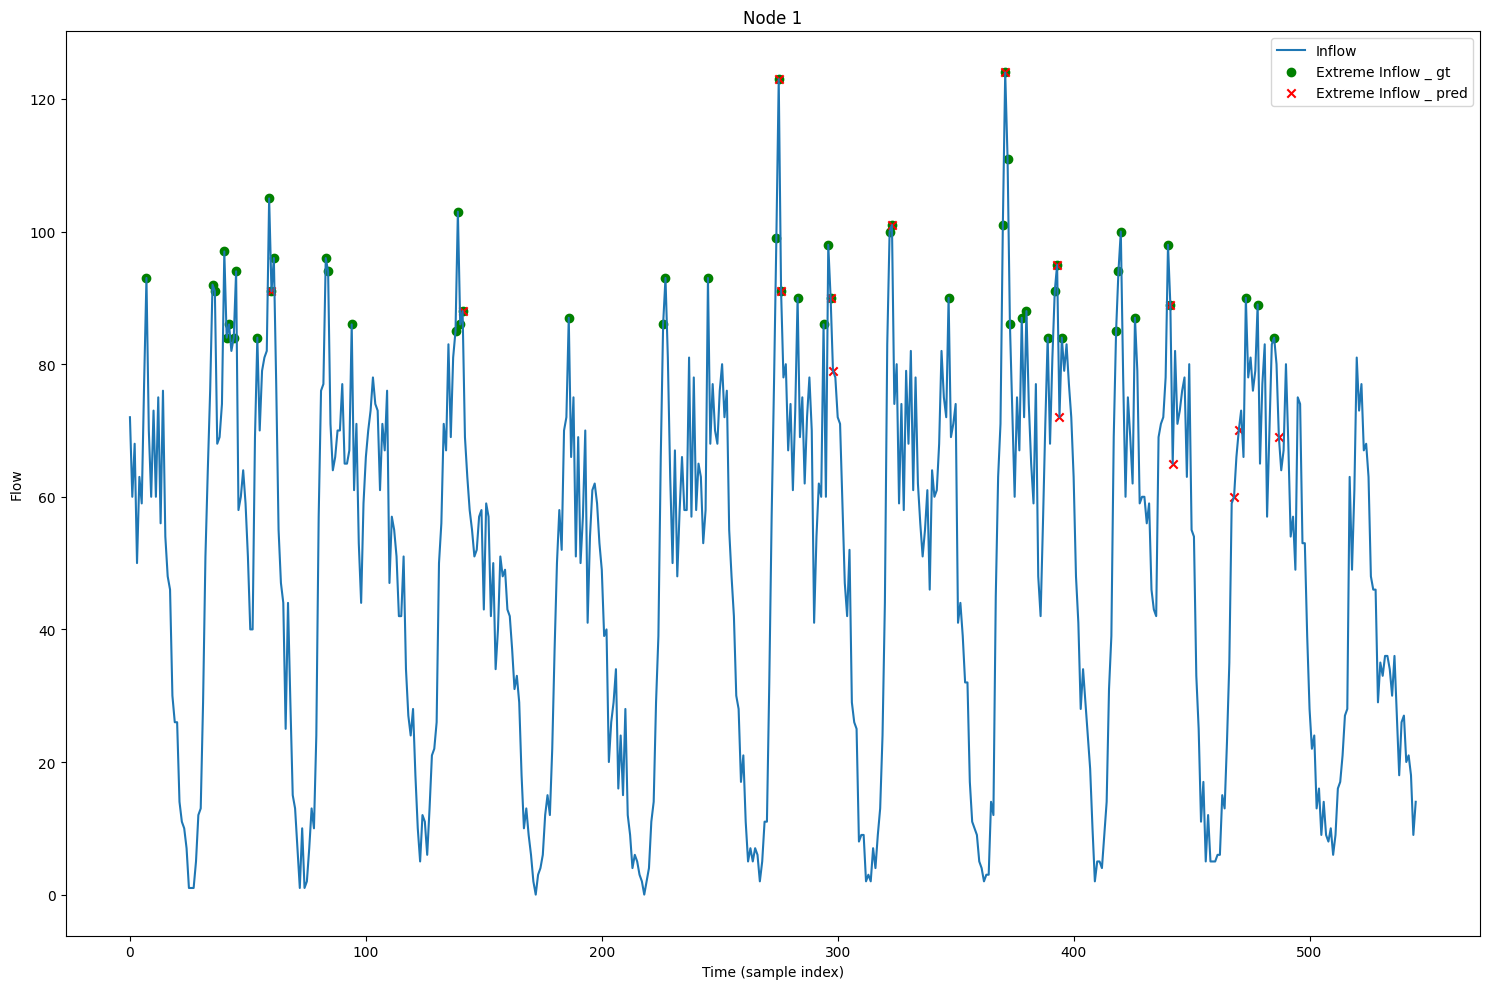

In [14]:
## plot from the newly defined binary tensor

import numpy as np
import matplotlib.pyplot as plt

# Assuming y_train and extreme_indicator_tensor are defined with the same shape
# and extreme_indicator_tensor contains 1 where there's an extreme event and 0 otherwise

# Set up the plot
plt.figure(figsize=(15, 10))

# Plotting for the first node (as the loop range is 1, it plots only the first node)
for node_index in range(1):
    inflow = y_true[:, 0, node_index, 0]
    # outflow = y_train[:, 0, node_index, 1]
    
    # Extract extreme indicators for inflow and outflow
    extreme_inflow_indicator = evs_pred[:, 0, node_index, 0]
    extreme_inflow_indicator_true = evs_true[:, 0, node_index, 0]
    # print("extreme_inflow_indicator", extreme_inflow_indicator)
    # extreme_outflow_indicator = extreme_values_binary_tensor[:, 0, node_index, 1]
    
    # Identify indices where extreme events occur
    extreme_inflow_indices = np.where(extreme_inflow_indicator >= .5)[0]
    extreme_inflow_indices_true = np.where(extreme_inflow_indicator_true == 1)[0]
    # extreme_outflow_indices = np.where(extreme_outflow_indicator == 1)[0]

    # Plotting inflow and outflow
    plt.subplot(1, 1, node_index + 1)
    plt.plot(inflow, label='Inflow')
    # plt.plot(outflow, label='Outflow')

    # Marking the extreme events
    plt.scatter(extreme_inflow_indices_true, inflow[extreme_inflow_indices_true], color='green', label='Extreme Inflow _ gt', marker='o')
    plt.scatter(extreme_inflow_indices, inflow[extreme_inflow_indices], color='red', label='Extreme Inflow _ pred', marker='x')
    
    # plt.scatter(extreme_outflow_indices, outflow[extreme_outflow_indices], color='blue', label='Extreme Outflow', marker='x')

    plt.title(f'Node {node_index + 1}')
    plt.xlabel('Time (sample index)')
    plt.ylabel('Flow')
    plt.legend()

plt.tight_layout()
plt.show()
